# Mostra do funcionamento do projeto

In [1]:
import re
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

## Definição da classe

In [8]:
class Emparelhamento:
    """
    Classe para implementar o algoritmo de emparelhamento estável máximo.
    Utiliza uma variação do algoritmo de Gale-Shapley e possui algumas
    funções auxiliares para manipulação de dados e visualização de grafos.
    """

    def __init__(self) -> None:
        self.grafo = nx.Graph()
        self.alunos = {}
        self.projetos = {}

    def organizar_dados(self, alunos_txt: str = "alunos.txt", projetos_txt: str = "projetos.txt") -> None:
        """
        Função para extrair os dados de entrada e atualizar os dicionários de alunos e projetos.
        
        Args:
            alunos (str): caminho para o txt dos alunos
            projetos (str): caminho para o txt dos projetos
        """
        try:
            # Lendo o arquivo de projetos
            with open(projetos_txt, encoding="utf-8") as f:
                linhas = f.readlines()
            for linha in linhas:
                linha = linha.strip()
                if linha or not linha.startswith("//"):
                    # Aplica um regex para extrair os dados
                    match = re.match(r"\((P\d+),\s*(\d+),\s*(\d+)\)", linha)
                    if match:
                        codigo, vagas, nota_min = match.groups()
                        # Atualiza o dicionário com as informações necessárias
                        self.projetos[codigo] = {"vagas": int(vagas), "nota_min": int(nota_min)}

            # Lendo o arquivo de alunos
            with open(alunos_txt, encoding="utf-8") as f:
                linhas = f.readlines()
            for linha in linhas:
                linha = linha.strip()
                if linha or not linha.startswith("//"):
                    # Aplica outro regex para extrair os dados
                    match = re.match(r"\((A\d+)\):\(([^)]+)\)\s*\((\d+)\)", linha)
                    if match:
                        codigo, prefs, nota = match.groups()
                        preferencias = [pref.strip() for pref in prefs.split(",")]
                        self.alunos[codigo] = {"preferencias": preferencias, "nota": int(nota)}

            print("Dados organizados com sucesso!")

        except Exception as e:
            print(f"Algo deu errado! {e}")

    def exibir_grafo(self, titulo: str = "Grafo Bipartido Inicial") -> None:
        """
        Exibe um grafo bipartido com rótulos
        
        Args:
            titulo (str): Título do grafo a ser exibido
        """
        if not self.grafo.nodes():
            print("O grafo fornecido para visualização está vazio.")
            return
        # Identifica os conjuntos bipartidos com base no atributo 'bipartite'
        set_alunos = {n for n, d in self.grafo.nodes(data=True) if d.get("bipartite") == 0}
        set_projetos = {n for n, d in self.grafo.nodes(data=True) if d.get("bipartite") == 1}

        # Se a identificação bipartida falhar, tentamos inferir com base nos nomes ou total de nós.
        if not set_alunos and not set_projetos:
            set_alunos = {n for n in self.grafo.nodes() if n.startswith('A')}
            set_projetos = {n for n in self.grafo.nodes() if n.startswith('P')}
            if not set_alunos or not set_projetos:
                print("Aviso: Não foi possível identificar as partições bipartidas (bipartite=0/1 ou 'A'/'P' no nome).")
                print("O layout bipartido pode não ser aplicado corretamente.")
                # Se ainda assim não der, use um layout genérico
                pos = nx.spring_layout(self.grafo)
            else:
                # Caso os atributos não existam, mas os nomes sigam o padrão 'A'/'P'
                pos = nx.bipartite_layout(self.grafo, set_alunos)
        else:
            # Caso os atributos estejam corretos, use o layout bipartido
            pos = nx.bipartite_layout(self.grafo, set_alunos)
        # Determina o espaçamento vertical e a altura da figura de forma dinâmica
        # para melhor acomodar a quantidade de nós.
        num_max_nodes_side = max(len(set_alunos), len(set_projetos))
        espacamento_vertical = 1.0 # Espaçamento base entre os nós
        
        # Ajusta o node_size e font_size com base no número de nós
        if num_max_nodes_side > 100:
            node_size = 150
            font_size = 5
        elif num_max_nodes_side > 50:
            node_size = 250
            font_size = 6
        else:
            node_size = 400
            font_size = 7

        altura_figura = max(10, num_max_nodes_side * espacamento_vertical * 0.2) 
        plt.figure(figsize=(15, altura_figura)) # Aumentei um pouco a largura para rótulos
        # Desenha os nós dos alunos
        nx.draw_networkx_nodes(self.grafo, pos, nodelist=list(set_alunos), node_color="#87CEFA", # Azul claro
                            node_size=node_size, edgecolors='black', label="Alunos", alpha=0.9)
        # Desenha os nós dos projetos
        nx.draw_networkx_nodes(self.grafo, pos, nodelist=list(set_projetos), node_color="#98FB98", # Verde claro
                            node_size=node_size, edgecolors='black', label="Projetos", alpha=0.9)
        # Desenha as arestas
        nx.draw_networkx_edges(self.grafo, pos, width=0.8, alpha=0.5, edge_color="gray")
        # Desenha os rótulos dos nós
        nx.draw_networkx_labels(self.grafo, pos, font_size=font_size, font_weight='bold')
        plt.title(titulo, fontsize=16, pad=20) # Título maior e com mais espaçamento
        plt.axis("off") # Desliga os eixos
        plt.tight_layout() # Ajusta o layout para evitar sobreposição
        plt.show() # Exibe a janela do grafo

    def Emparelhamento_final(self)-> None:
        # Matriz de emparelhamento 
        # Ordenar os alunos e projetos para fixar a ordem da matriz
        alunos_ordenados = list(self.alunos.keys())
        projetos_ordenados = list(self.projetos.keys())

        # Cria matriz vazia 
        matriz_final = [['' for _ in projetos_ordenados] for _ in alunos_ordenados]

        # Preenche com '*' onde há emparelhamento 
        for aluno, projeto in self.grafo.edges():
            if aluno in self.alunos and projeto in self.projetos:
                i = alunos_ordenados.index(aluno)
                j = projetos_ordenados.index(projeto)
                matriz_final[i][j] = '*'

        # Converte para DataFrame e salva no csv
        df = pd.DataFrame(matriz_final, index=alunos_ordenados, columns=projetos_ordenados)
        df.to_csv("matriz_emparelhamento_final.csv")

    def exibir_escolhas(self) -> None:
        """
        Exibe as turmas e projetos emparelhados, mostrando o projeto e os alunos emparelhados com ele,
        """
        print("\nEmparelhamento final:")
        for projeto in self.projetos.keys():
            alunos_no_projeto = [aluno for aluno, proj in self.grafo.edges() if proj == projeto]
            if alunos_no_projeto:
                print(f"Projeto {projeto}: Alunos emparelhados: {', '.join(alunos_no_projeto)}")
            else:
                print(f"Projeto {projeto}: Nenhum aluno emparelhado.")

    def gale_shapley(self, iteracoes: int) -> None:
        """
        Implementa a variação do algoritmo de Gale-Shapley para encontrar um emparelhamento estável máximo.

        Args:
            iteracoes (int): Número de iterações para o emparelhamento
        """

        # Inicializa as estruturas necessárias
        alunos_disponiveis = list(self.alunos.keys())
        # Os projetos com vagas ocupadas
        vagas_ocupadas = {projeto: [] for projeto in self.projetos.keys()}
        # As propostas já feitas pelos alunos
        propostas = {aluno: [] for aluno in self.alunos.keys()}

        for i in range(iteracoes):
            # print(f"Iteração {i + 1} de {iteracoes}")

            # Condições de parada
            # 1. Se não tiver alunos disponíveis para serem emparelhados
            if not alunos_disponiveis:
                print("Emparelhamento máximo alcançado: todos os alunos foram processados")
                self.exibir_grafo(titulo="Grafo Bipartido - Emparelhamento Final")
                break

            # 2. Se todos os alunos disponíveis não tiverem mais preferências
            alunos_sem_opcoes = []
            for aluno in alunos_disponiveis:
                preferencias_validas = [pref for pref in self.alunos[aluno]['preferencias']
                                        if pref in self.projetos and pref not in propostas[aluno]]
                if not preferencias_validas:
                    alunos_sem_opcoes.append(aluno)

            if len(alunos_disponiveis) == len(alunos_sem_opcoes):
                print("Emparelhamento máximo alcançado: nenhum aluno pode fazer mais propostas")
                print(f"Quantidade de iterações: {i + 1}")
                self.exibir_grafo(titulo="Grafo Bipartido - Emparelhamento Final")
                break

            # Pega um aluno para tentar o emparelhamento
            aluno = alunos_disponiveis.pop(0)
            # Informações do aluno
            nota_aluno = self.alunos[aluno]['nota']
            pref_aluno = self.alunos[aluno]['preferencias']

            # Encontrar o próximo projeto na lista de preferênias do aluno
            projeto_escolhido = None
            for projeto in pref_aluno:
                # Se o aluno ainda não tiver feito proposta pra esse projeto
                if projeto not in propostas[aluno] and projeto in self.projetos:
                    # A nota do aluno tem que ser necessária
                    if nota_aluno >= self.projetos[projeto]['nota_min']:
                        projeto_escolhido = projeto
                        break

            # Se existe um projeto escolhido, adiciona ele no emparelhamento
            if projeto_escolhido:
                # Atualiza as propostas feitas do aluno
                propostas[aluno].append(projeto_escolhido)
                # Pega as quantidade de vagas do projeto escolhido
                qtd_vagas = self.projetos[projeto_escolhido]['vagas']

                # Checa se existe vagas no projeto
                if len(vagas_ocupadas[projeto_escolhido]) < qtd_vagas:
                    # Se tem vaga, coloca o aluno na vaga
                    vagas_ocupadas[projeto_escolhido].append(aluno)
                    # Adiciona uma conexão no grafo de emparelhamento
                    self.grafo.add_edge(aluno, projeto_escolhido, nota=nota_aluno)
                    print(f"Aluno {aluno} emparelhado com o projeto {projeto_escolhido}")

                else:
                    # Se o projeto está cheio, verifica se o aluno tem preferência
                    alunos_no_projeto = vagas_ocupadas[projeto_escolhido]
                    # Pega o aluno com menor nota dentro do projeto
                    aluno_menor_nota = min(alunos_no_projeto, key=lambda a: (self.alunos[a]["nota"], a))

                    nota_menor = self.alunos[aluno_menor_nota]["nota"]
                    if nota_aluno > nota_menor:
                        # Remove o aluno com menor nota do projeto
                        vagas_ocupadas[projeto_escolhido].remove(aluno_menor_nota)
                        vagas_ocupadas[projeto_escolhido].append(aluno)

                        # Remove a conexão entre o aluno anterior e adiciona uma nova
                        self.grafo.remove_edge(aluno_menor_nota, projeto_escolhido)
                        self.grafo.add_edge(aluno, projeto_escolhido, nota=nota_aluno)
                        
                        print(f"Aluno {aluno} emparelhado com o projeto {projeto_escolhido}, substituindo {aluno_menor_nota}.")

                        preferencias_restantes = [pref for pref in self.alunos[aluno_menor_nota]['preferencias']
                                                  if pref in self.projetos and pref not in propostas[aluno_menor_nota]]
                        if preferencias_restantes:
                            alunos_disponiveis.append(aluno_menor_nota)
                    else:
                        # Se o aluno não é melhor, volta para a lista de disponíveis
                        alunos_disponiveis.append(aluno)
                        # print(f"Aluno {aluno} não foi emparelhado com o projeto {projeto_escolhido}, pois não é melhor que os já emparelhados.")
            #else:
                # print(f"Aluno {aluno} não escolheu nenhum projeto válido nesta iteração.")

            if i % 100 == 0:
                self.exibir_grafo(titulo=f"Grafo Bipartido - Iteração {i}")

        print("Emparelhamento finalizado.")
        self.exibir_escolhas()

## Resolução

In [9]:
emparelhamento = Emparelhamento()
emparelhamento.organizar_dados()

Dados organizados com sucesso!


Aluno A1 emparelhado com o projeto P1


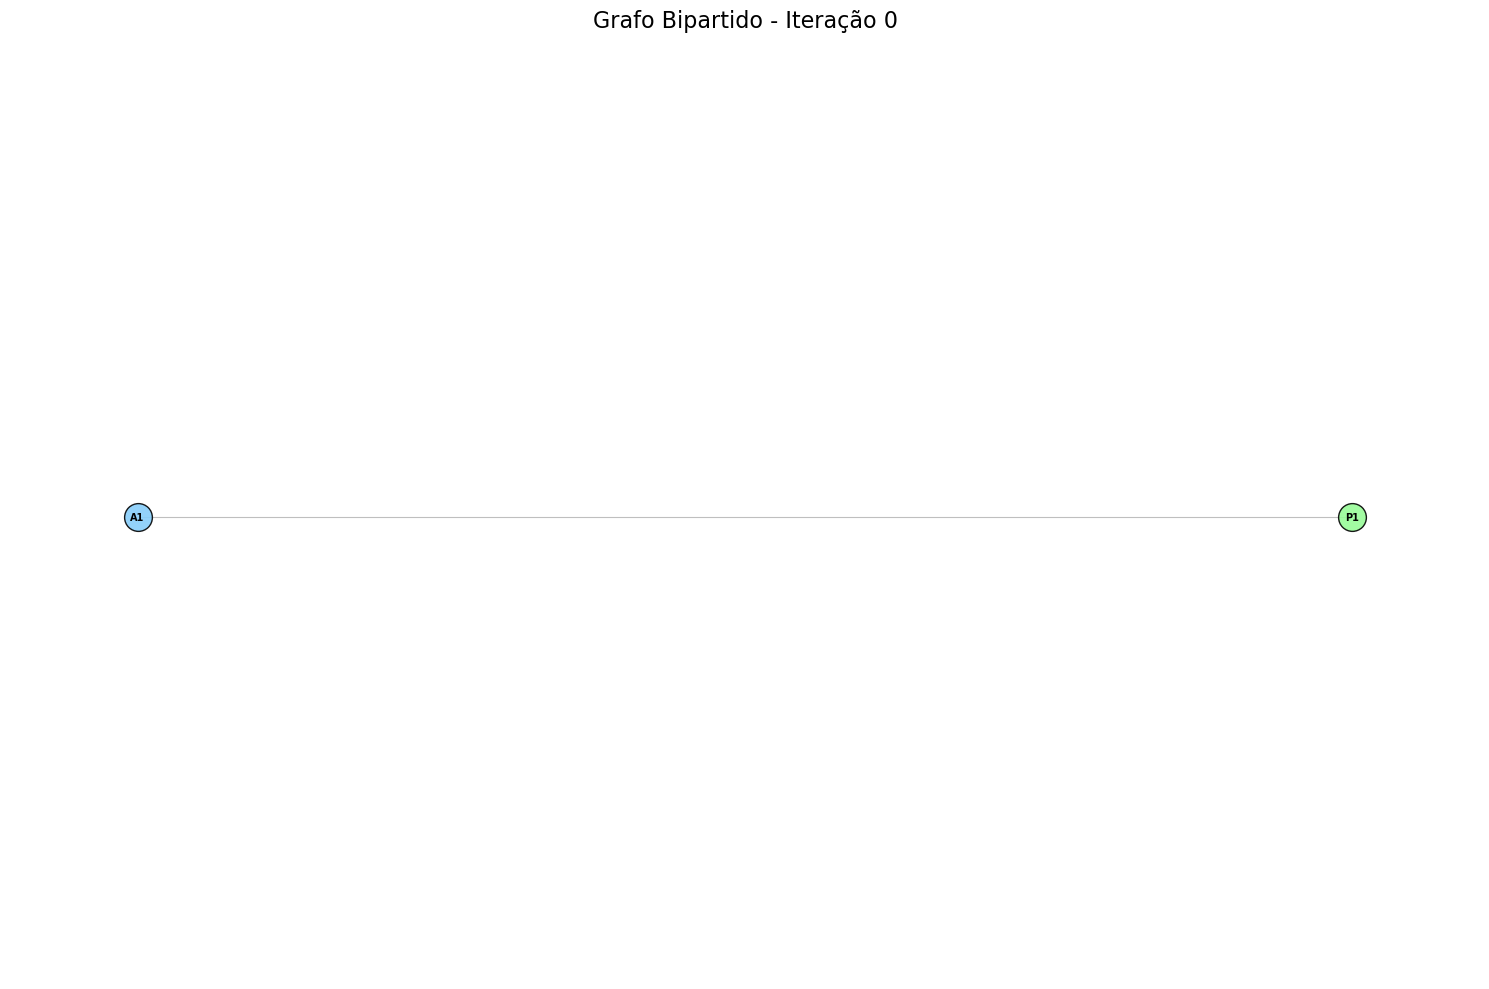

Aluno A2 emparelhado com o projeto P1
Aluno A4 emparelhado com o projeto P3
Aluno A5 emparelhado com o projeto P28
Aluno A6 emparelhado com o projeto P40
Aluno A7 emparelhado com o projeto P41
Aluno A8 emparelhado com o projeto P6
Aluno A10 emparelhado com o projeto P43
Aluno A11 emparelhado com o projeto P12
Aluno A16 emparelhado com o projeto P5
Aluno A17 emparelhado com o projeto P21
Aluno A18 emparelhado com o projeto P8
Aluno A21 emparelhado com o projeto P17
Aluno A22 emparelhado com o projeto P18
Aluno A23 emparelhado com o projeto P9
Aluno A24 emparelhado com o projeto P10
Aluno A25 emparelhado com o projeto P34
Aluno A27 emparelhado com o projeto P41
Aluno A31 emparelhado com o projeto P12, substituindo A11.
Aluno A32 emparelhado com o projeto P2
Aluno A33 emparelhado com o projeto P3
Aluno A34 emparelhado com o projeto P4
Aluno A35 emparelhado com o projeto P5
Aluno A41 emparelhado com o projeto P14
Aluno A42 emparelhado com o projeto P16
Aluno A43 emparelhado com o projeto P

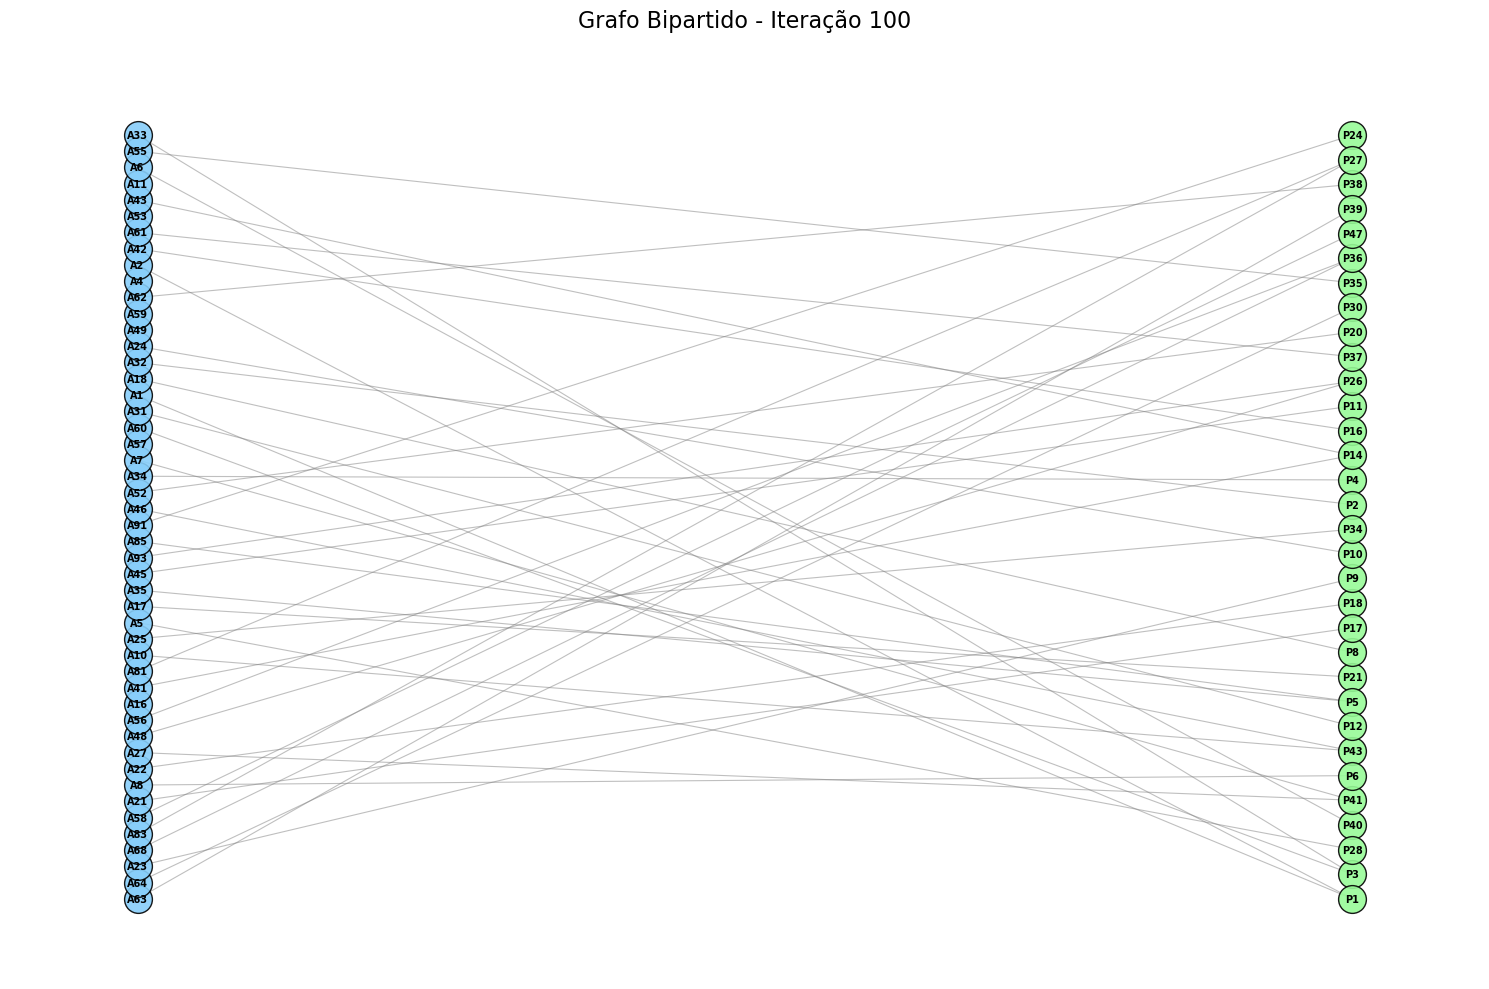

Aluno A104 emparelhado com o projeto P25
Aluno A107 emparelhado com o projeto P41, substituindo A27.
Aluno A110 emparelhado com o projeto P10
Aluno A117 emparelhado com o projeto P7
Aluno A127 emparelhado com o projeto P28, substituindo A5.
Aluno A129 emparelhado com o projeto P29
Aluno A135 emparelhado com o projeto P15
Aluno A144 emparelhado com o projeto P22
Aluno A155 emparelhado com o projeto P45
Aluno A181 emparelhado com o projeto P17, substituindo A21.
Aluno A187 emparelhado com o projeto P7
Aluno A188 emparelhado com o projeto P8
Aluno A197 emparelhado com o projeto P41, substituindo A7.
Aluno A14 emparelhado com o projeto P15


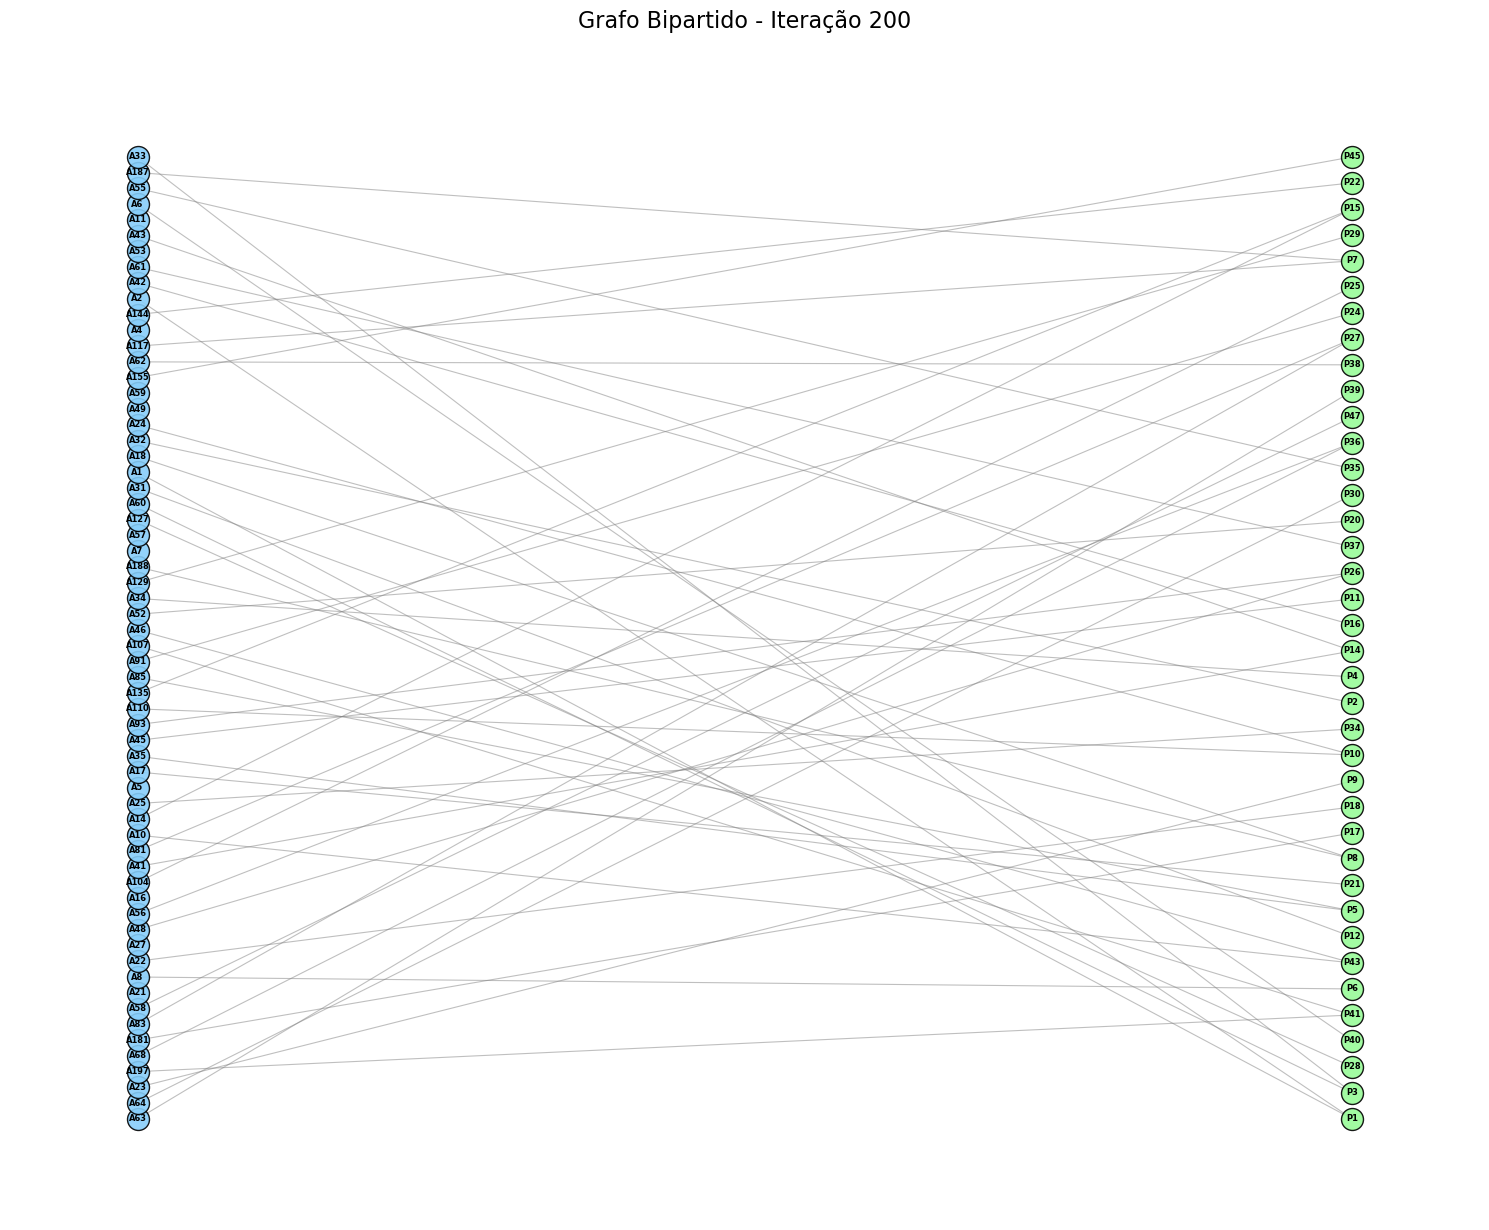

Aluno A26 emparelhado com o projeto P9
Aluno A50 emparelhado com o projeto P10
Aluno A53 emparelhado com o projeto P45
Aluno A69 emparelhado com o projeto P29
Aluno A82 emparelhado com o projeto P27
Aluno A84 emparelhado com o projeto P40, substituindo A6.
Aluno A137 emparelhado com o projeto P21, substituindo A17.
Aluno A159 emparelhado com o projeto P49
Aluno A200 emparelhado com o projeto P10, substituindo A110.
Aluno A57 emparelhado com o projeto P18


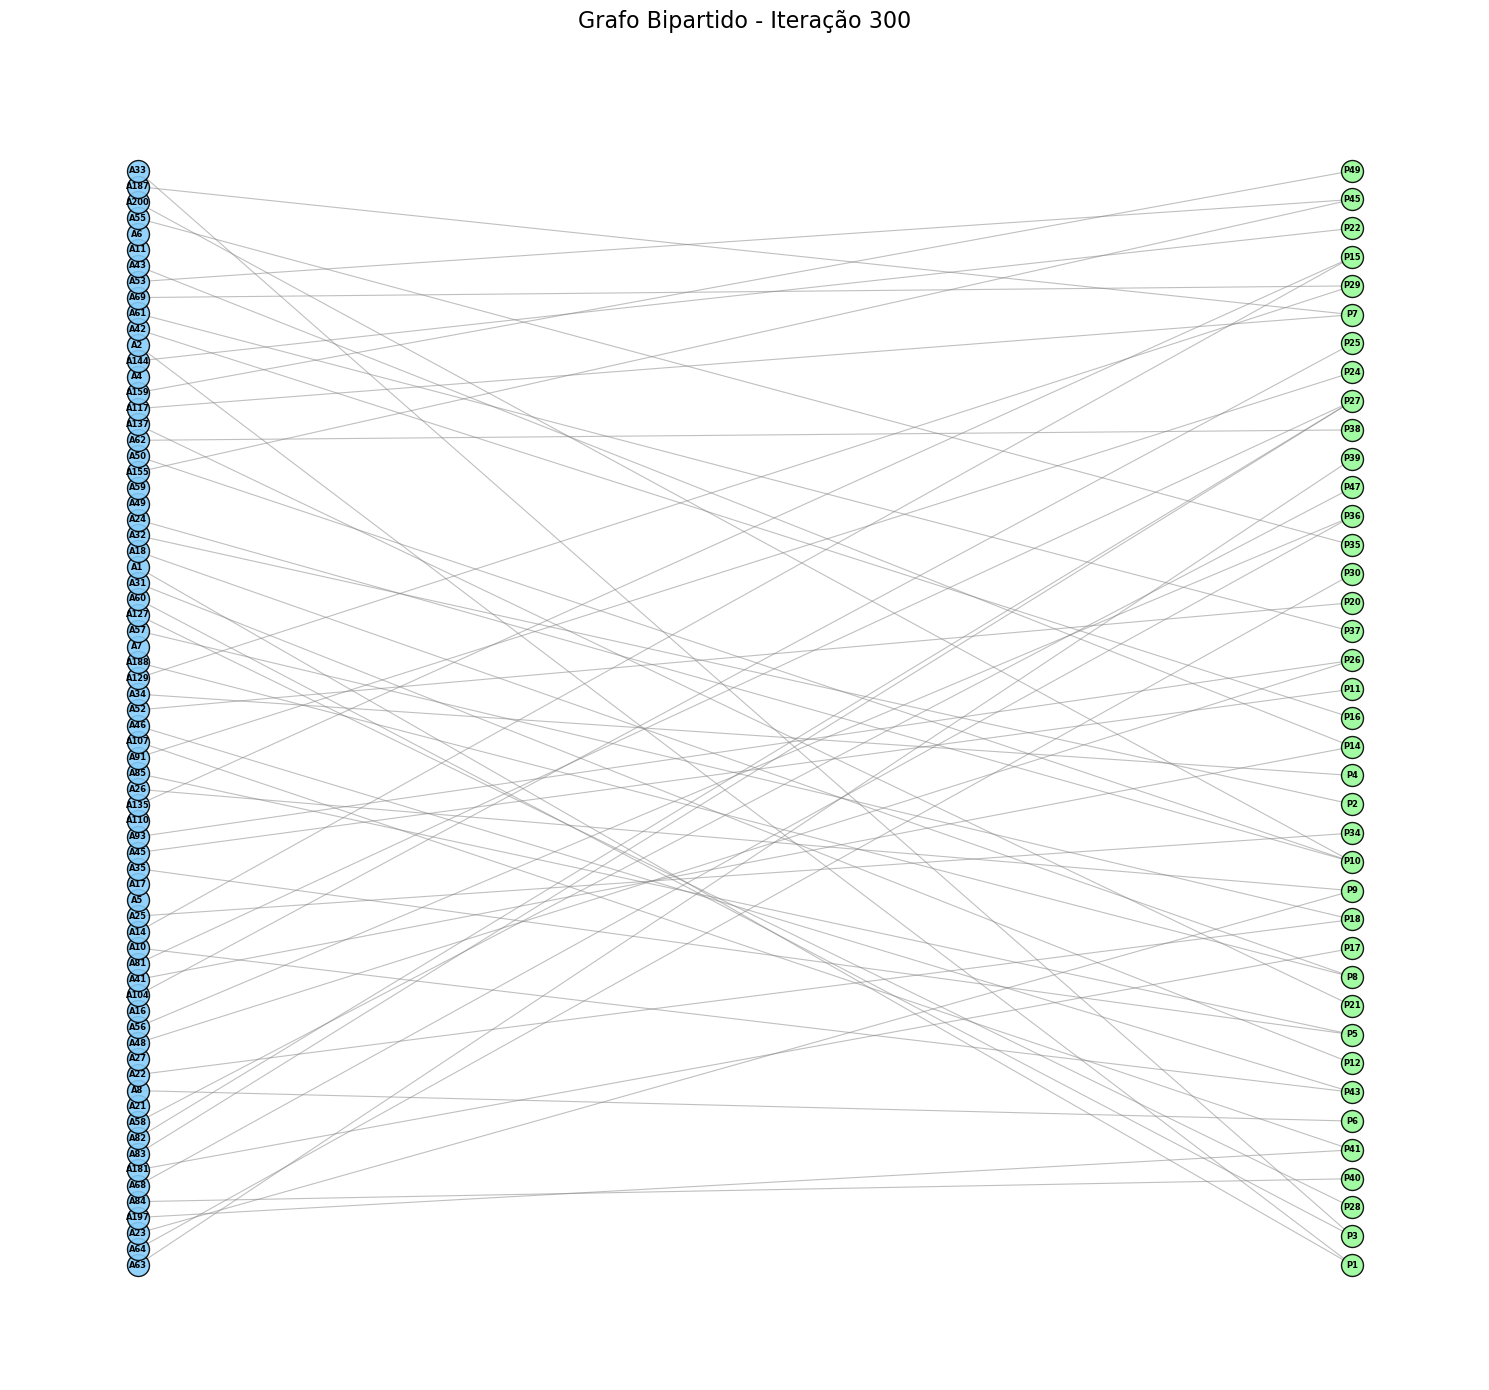

Aluno A100 emparelhado com o projeto P20, substituindo A52.
Aluno A157 emparelhado com o projeto P18, substituindo A22.
Aluno A177 emparelhado com o projeto P18, substituindo A57.
Emparelhamento máximo alcançado: nenhum aluno pode fazer mais propostas
Quantidade de iterações: 354


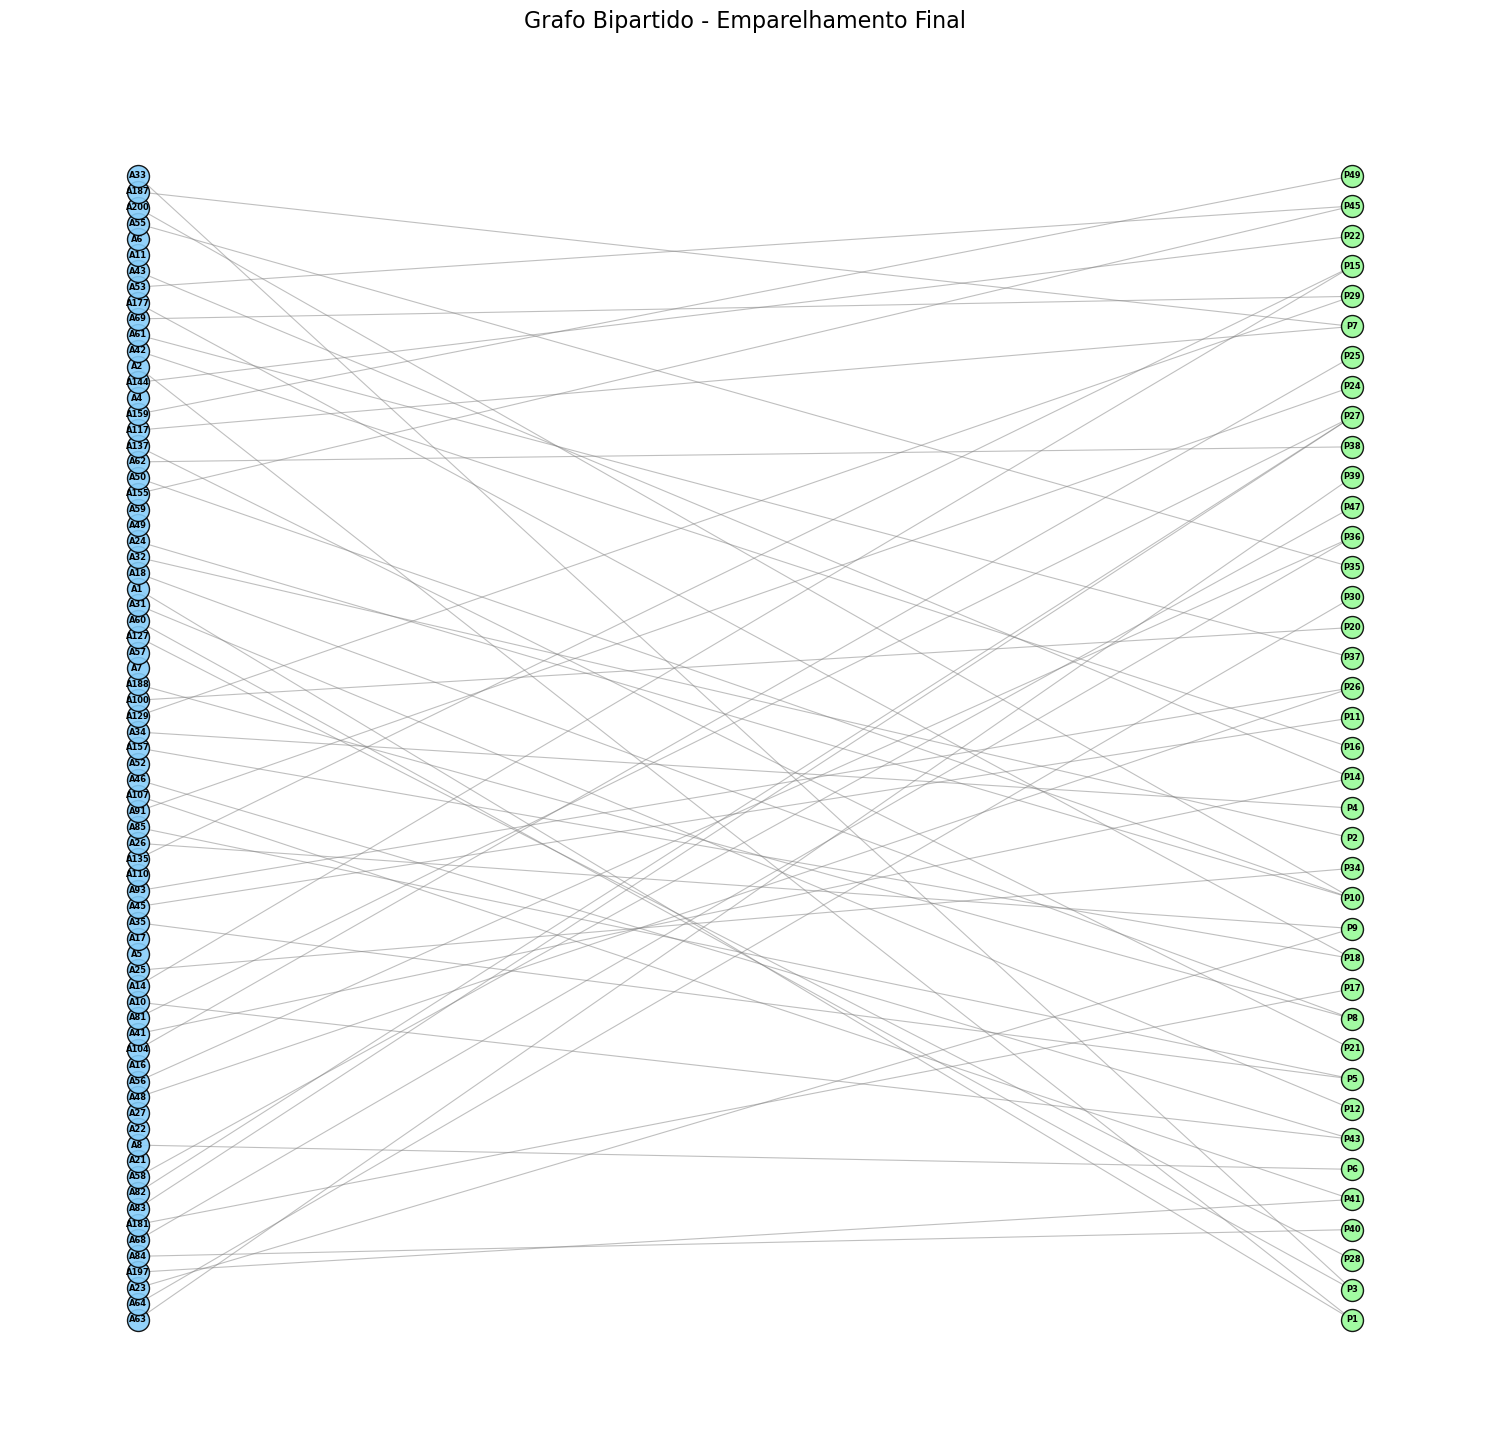

Emparelhamento finalizado.

Emparelhamento final:
Projeto P1: Alunos emparelhados: A1
Projeto P2: Alunos emparelhados: A32
Projeto P3: Nenhum aluno emparelhado.
Projeto P4: Alunos emparelhados: A34
Projeto P5: Nenhum aluno emparelhado.
Projeto P6: Alunos emparelhados: A8
Projeto P7: Alunos emparelhados: A117
Projeto P8: Alunos emparelhados: A18
Projeto P9: Alunos emparelhados: A23
Projeto P10: Alunos emparelhados: A24
Projeto P11: Alunos emparelhados: A45
Projeto P12: Nenhum aluno emparelhado.
Projeto P13: Nenhum aluno emparelhado.
Projeto P14: Alunos emparelhados: A41
Projeto P15: Alunos emparelhados: A135
Projeto P16: Alunos emparelhados: A42
Projeto P17: Nenhum aluno emparelhado.
Projeto P18: Nenhum aluno emparelhado.
Projeto P19: Nenhum aluno emparelhado.
Projeto P20: Nenhum aluno emparelhado.
Projeto P21: Nenhum aluno emparelhado.
Projeto P22: Alunos emparelhados: A144
Projeto P23: Nenhum aluno emparelhado.
Projeto P24: Alunos emparelhados: A91
Projeto P25: Alunos emparelhados: A1

In [10]:
emparelhamento.gale_shapley(iteracoes=1000)

In [11]:
emparelhamento.Emparelhamento_final()

# Exibe o número de nós e arestas no grafo
print(f"Número de nós: {len(emparelhamento.grafo.nodes())}")
print(f"Número de arestas: {len(emparelhamento.grafo.edges())}")

Número de nós: 112
Número de arestas: 58
